# Проект "Дашборд конверсий"

In [1]:
import pandas as pd
import numpy as np
import requests

In [2]:
visits_df = pd.read_csv('visits_1k.csv')
regs_df = pd.read_csv('regs_1k.csv')

In [3]:
visits_df.head()

,uuid,platform,user_agent,date
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01T13:29:22
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01T16:44:28
2,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-06T06:12:36
3,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-01T20:16:37
4,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-05T17:42:47


In [4]:
visits_df.describe()

,uuid,platform,user_agent,date
count,1000,1000,1000,1000
unique,519,3,28,996
top,251a0926-ece3-4d77-aa42-ab569fdf9fe2,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T08:01:45
freq,4,954,71,2


In [5]:
regs_df.head()

,date,user_id,email,platform,registration_type
0,2023-03-01T00:25:39,8838849,joseph95@example.org,web,google
1,2023-03-01T14:53:01,8741065,janetsuarez@example.net,web,yandex
2,2023-03-01T14:27:36,1866654,robert67@example.org,web,google
3,2023-03-01T02:42:34,1577584,elam@example.net,web,apple
4,2023-03-01T10:27:14,4765395,stephanie68@example.net,web,yandex


In [6]:
regs_df.describe()

,user_id
count,1.000000e+03
mean,4.488623e+06
std,2.620568e+06
min,2.236800e+04
25%,2.235489e+06
50%,4.473044e+06
75%,6.779707e+06
max,8.881772e+06


In [7]:
rsp_visits = requests.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
visits_data = rsp_visits.json()
visits_df = pd.DataFrame(visits_data)

In [8]:
rsp_regs = requests.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01')
data_regs = rsp_regs.json()
regs_df = pd.DataFrame(data_regs)

In [9]:
regs_df['datetime'] = pd.to_datetime(regs_df['datetime'], format='%Y-%m-%dT%H:%M:%S')
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'], format='%Y-%m-%dT%H:%M:%S')

In [10]:
regs_df['date'] = regs_df['datetime'].dt.date
visits_df['date'] = visits_df['datetime'].dt.date

In [11]:
regs_grouped = regs_df.groupby(['date', 'platform']).size().reset_index(name='registrations')
visits_grouped = visits_df.groupby(['date', 'platform']).size().reset_index(name='visits')

In [12]:
merged_df = pd.merge(regs_grouped, visits_grouped, on=['date', 'platform'], how='outer').fillna(0)

merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['conversion'] = merged_df['registrations'] / merged_df['visits'].replace({0: 1}) * 100
merged_df['date_group'] = (merged_df['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')

merged_df.drop(columns='date', inplace=True)
merged_df.rename(columns={'platform': 'platform'}, inplace=True)

merged_df.to_json('./conversion.json', orient='columns')

In [13]:
ads_df = pd.read_csv('ads.csv')

In [14]:
ads_df['date'] = pd.to_datetime(ads_df['date'])
ads_df['date_group'] = ads_df['date'].dt.date
ads_grouped = ads_df.groupby(['date_group', 'utm_campaign'])['cost'].sum().reset_index()

In [15]:
ads_grouped['date_group'] = pd.to_datetime(ads_grouped['date_group'])
merged_df['date_group'] = pd.to_datetime(merged_df['date_group'], unit='ms')

In [16]:
result_df = pd.merge(merged_df, ads_grouped, on='date_group', how='left')
result_df.fillna({'cost': 0, 'utm_campaign': 'none'}, inplace=True)

In [17]:
result_df.to_json('ads.json', orient='records')

## Визуализация

In [38]:
import os
directory = './charts'
if not os.path.exists(directory):
    os.makedirs(directory)

In [18]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
import seaborn as sns

In [19]:
result_df['date_group'] = pd.to_datetime(result_df['date_group'], unit='ms')
filtered_df = result_df[(result_df['date_group'] >= '2023-01-01') & (result_df['date_group'] <= '2023-04-30')]

### Итоговые визиты

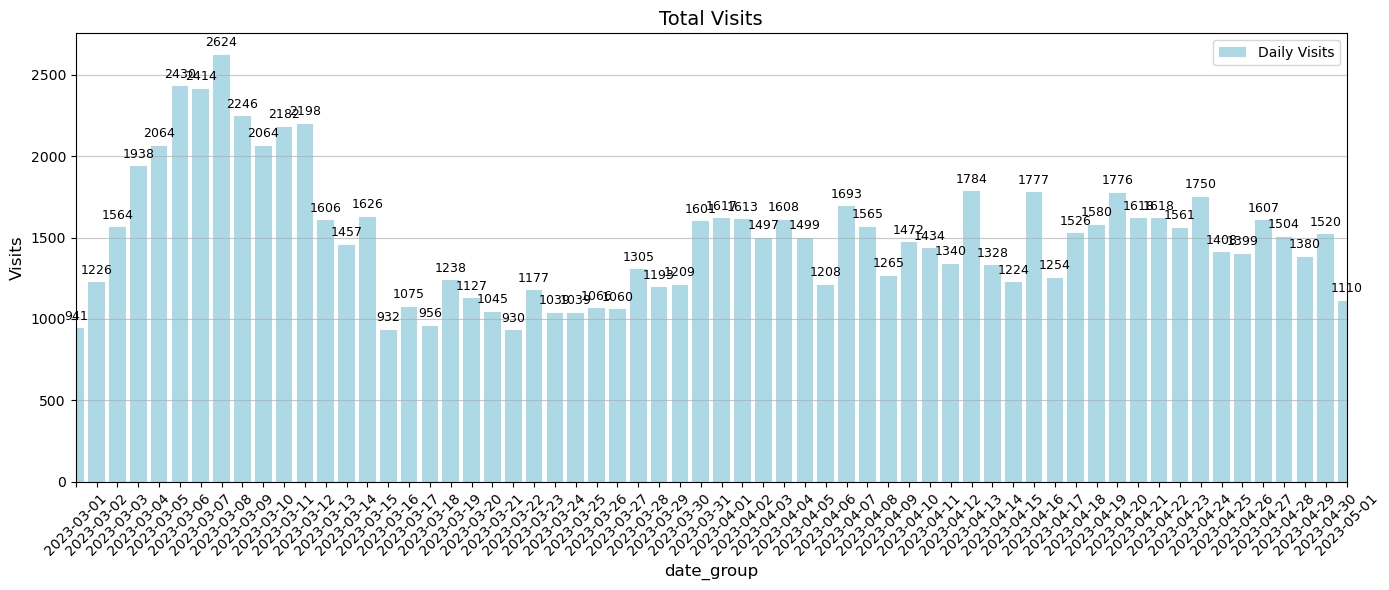

In [29]:
daily_visits = filtered_df.groupby('date_group')['visits'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.bar(daily_visits['date_group'], daily_visits['visits'], color='lightblue', label='Daily Visits')

plt.title('Total Visits', fontsize=14)
plt.xlabel('date_group', fontsize=12)
plt.ylabel('Visits', fontsize=12)
plt.xticks(daily_visits['date_group'], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.xlim(daily_visits['date_group'].iloc[0], daily_visits['date_group'].iloc[-1])

for x, y in zip(daily_visits['date_group'], daily_visits['visits']):
    plt.text(x, y + 0.02 * max(daily_visits['visits']), str(y), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./charts/total_visits.png')
plt.show()

### Итоговые визиты с разбивкой по платформам: web, android, ios

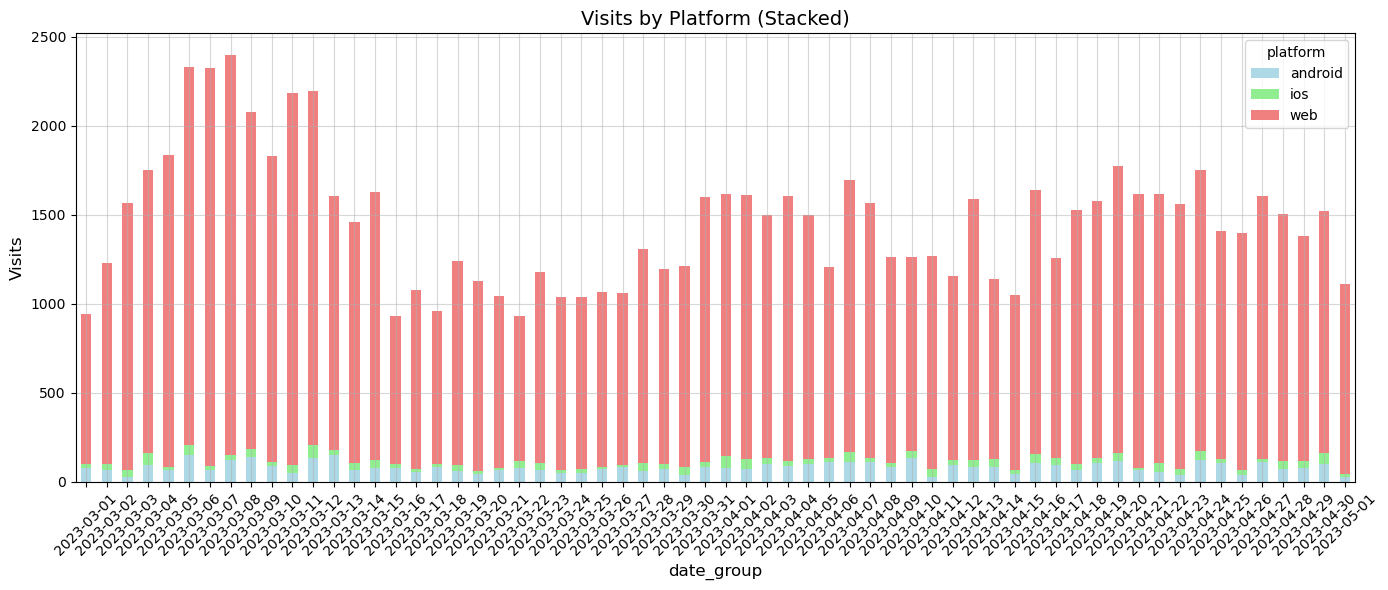

In [30]:
filtered_df_no_bot = filtered_df[filtered_df['platform'] != 'bot']

platform_visits_no_bot = filtered_df_no_bot.groupby(['date_group', 'platform'])['visits'].sum().unstack(fill_value=0)

plt.figure(figsize=(14, 6))

platform_visits_no_bot.plot(kind='bar', stacked=True, color=['lightblue', 'lightgreen', 'lightcoral'], ax=plt.gca())

plt.title('Visits by Platform (Stacked)', fontsize=14)
plt.xlabel('date_group', fontsize=12)
plt.ylabel('Visits', fontsize=12)
plt.xticks(ticks=range(len(platform_visits_no_bot.index)), labels=platform_visits_no_bot.index.date, rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.grid(axis='x', linestyle='-', alpha=0.5)

plt.legend(title='platform', fontsize=10)

plt.tight_layout()
plt.savefig('./charts/visits_by_platform.png')
plt.show()

### Итоговые регистрации

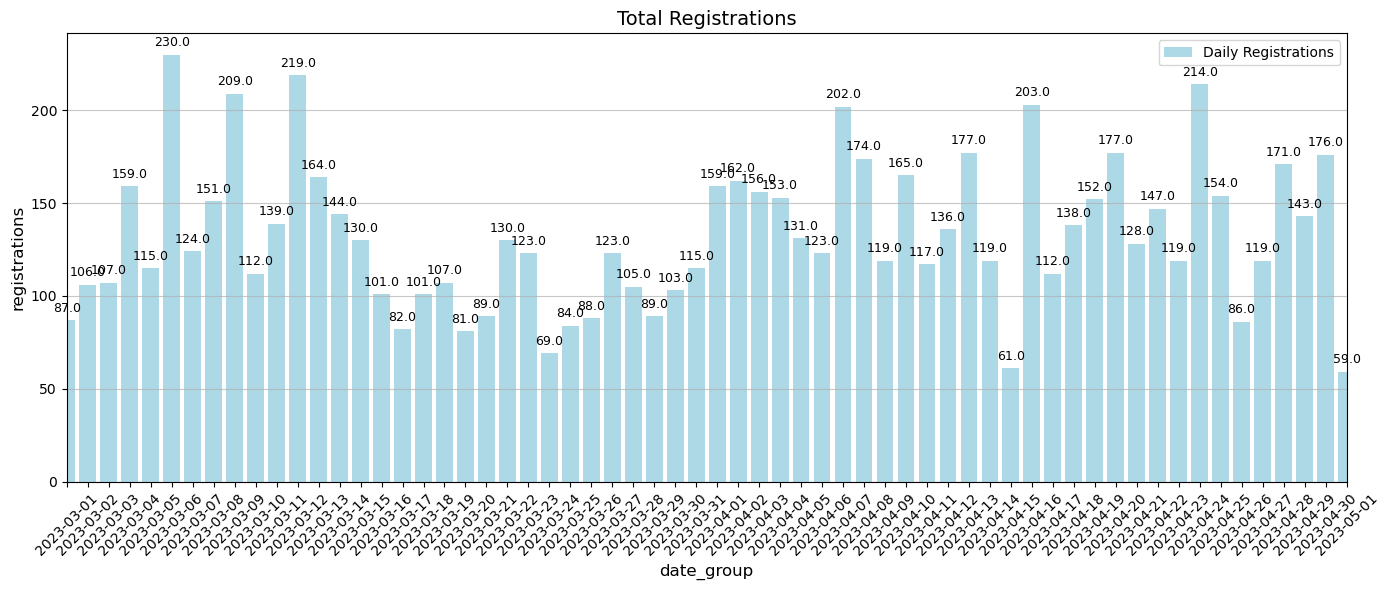

In [31]:
daily_visits = filtered_df.groupby('date_group')['registrations'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.bar(daily_visits['date_group'], daily_visits['registrations'], color='lightblue', label='Daily Registrations')

plt.title('Total Registrations', fontsize=14)
plt.xlabel('date_group', fontsize=12)
plt.ylabel('registrations', fontsize=12)
plt.xticks(daily_visits['date_group'], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.xlim(daily_visits['date_group'].iloc[0], daily_visits['date_group'].iloc[-1])

for x, y in zip(daily_visits['date_group'], daily_visits['registrations']):
    plt.text(x, y + 0.02 * max(daily_visits['registrations']), str(y), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./charts/total_registrations.png')
plt.show()

### Итоговые регистрации с разбивкой по платформам: web, android, ios

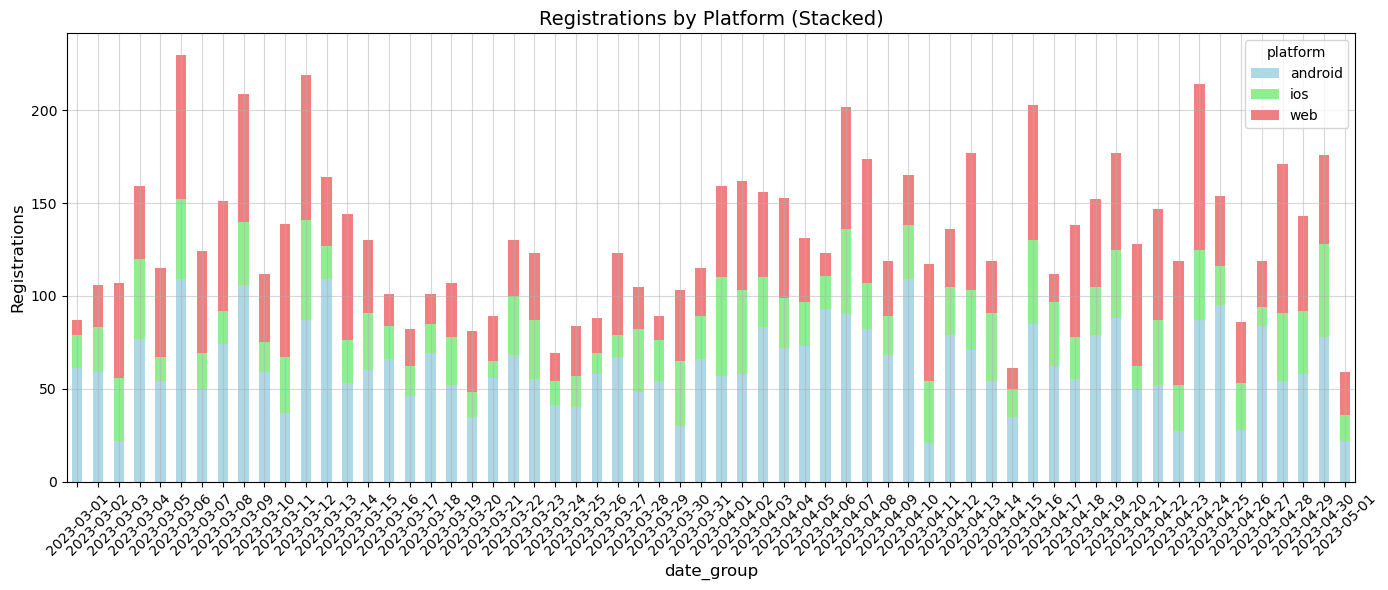

In [32]:
filtered_df_no_bot = filtered_df[filtered_df['platform'] != 'bot']

platform_visits_no_bot = filtered_df_no_bot.groupby(['date_group', 'platform'])['registrations'].sum().unstack(fill_value=0)

plt.figure(figsize=(14, 6))

platform_visits_no_bot.plot(kind='bar', stacked=True, color=['lightblue', 'lightgreen', 'lightcoral'], ax=plt.gca())

plt.title('Registrations by Platform (Stacked)', fontsize=14)
plt.xlabel('date_group', fontsize=12)
plt.ylabel('Registrations', fontsize=12)
plt.xticks(ticks=range(len(platform_visits_no_bot.index)), labels=platform_visits_no_bot.index.date, rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.grid(axis='x', linestyle='-', alpha=0.5)

plt.legend(title='platform', fontsize=10)

plt.tight_layout()
plt.savefig('./charts/registrations_by_platform.png')
plt.show()

### Итоговые конверсии

C:\Users\matve\AppData\Local\Temp\ipykernel_11968\2625528166.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df_weekly_no_bot.groupby('date_group').apply(lambda x: x['registrations'].sum() / x['visits'].sum() * 100)


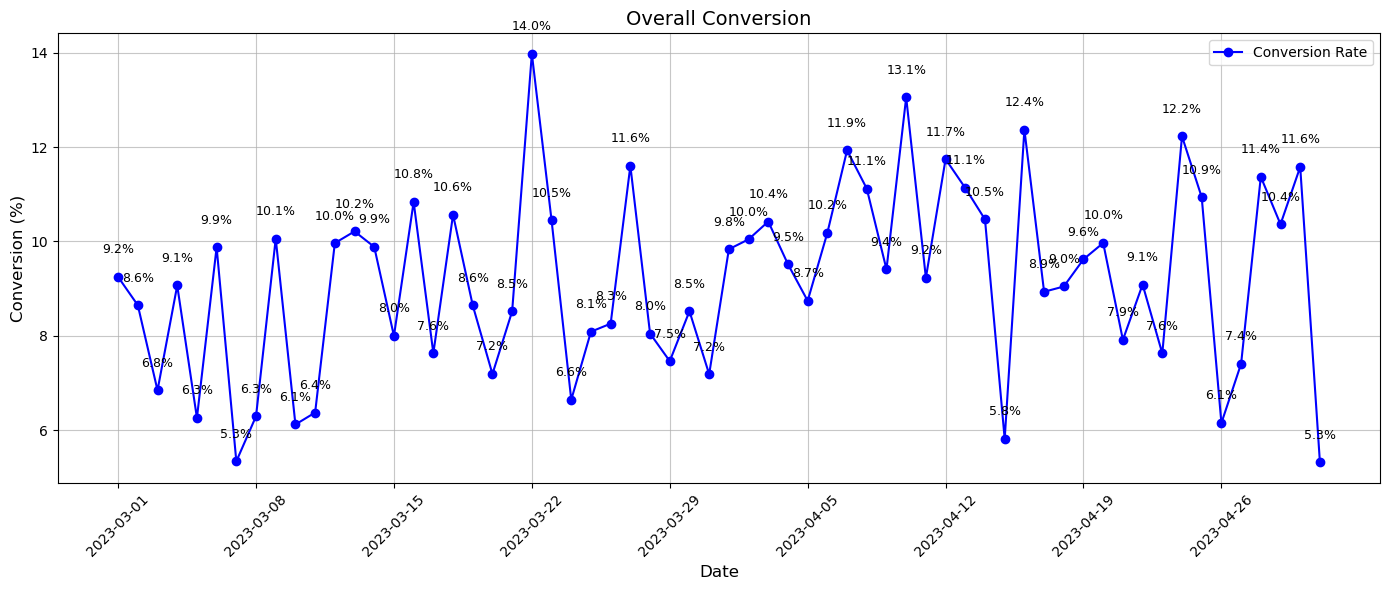

In [33]:
result_df_no_bot = result_df[result_df['platform'] != 'bot']

filtered_df_weekly_no_bot = result_df_no_bot[(result_df_no_bot['date_group'] >= '2023-03-01') & 
                                             (result_df_no_bot['date_group'] <= '2023-05-01')]

daily_conversion_no_bot = (
    filtered_df_weekly_no_bot.groupby('date_group').apply(lambda x: x['registrations'].sum() / x['visits'].sum() * 100)
).reset_index(name='conversion_rate')

plt.figure(figsize=(14, 6))

plt.plot(daily_conversion_no_bot['date_group'], daily_conversion_no_bot['conversion_rate'], marker='o', color='blue', label='Conversion Rate')

for x, y in zip(daily_conversion_no_bot['date_group'], daily_conversion_no_bot['conversion_rate']):
    plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)

weekly_ticks = pd.date_range(start='2023-03-01', end='2023-05-01', freq='7D')

plt.title('Overall Conversion', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Conversion (%)', fontsize=12)
plt.xticks(ticks=weekly_ticks, labels=weekly_ticks.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('./charts/overall_conversion.png')
plt.show()

### Конверсия по каждой платформе

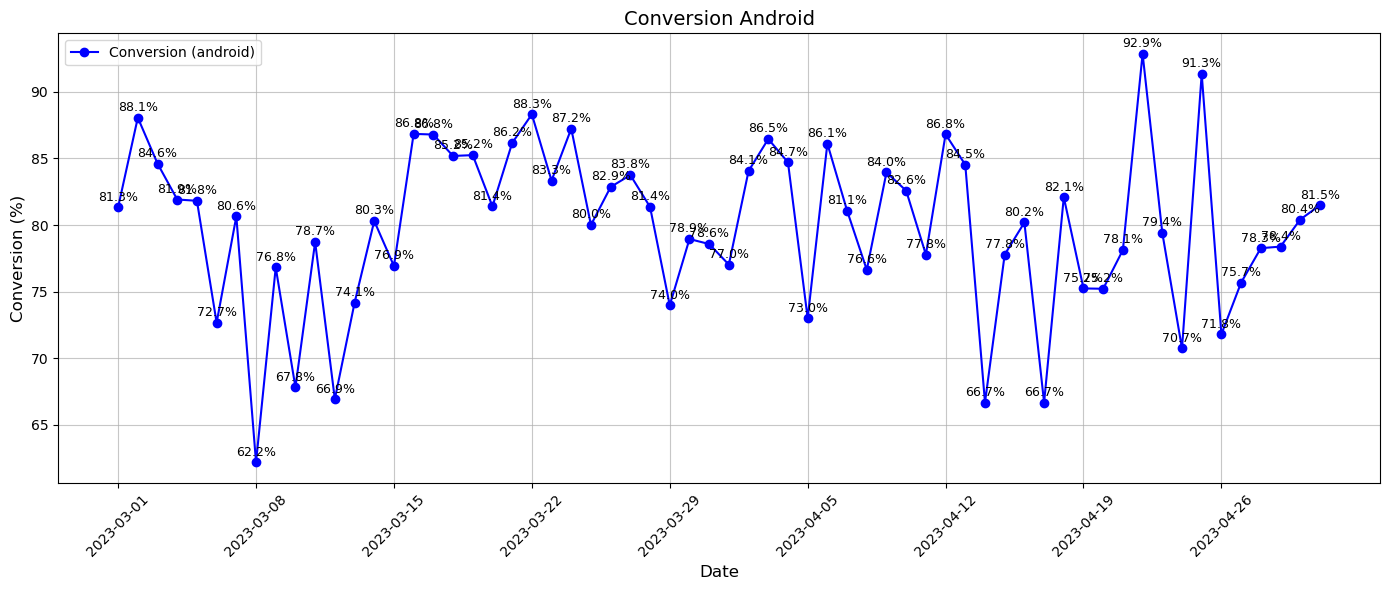

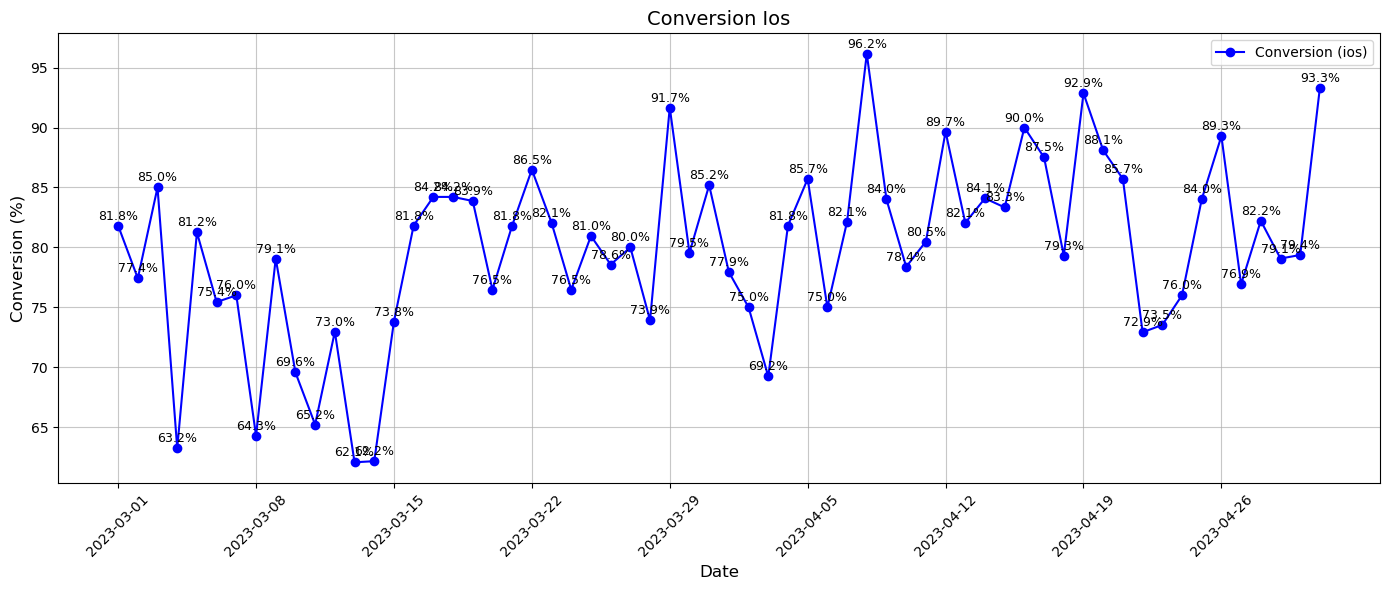

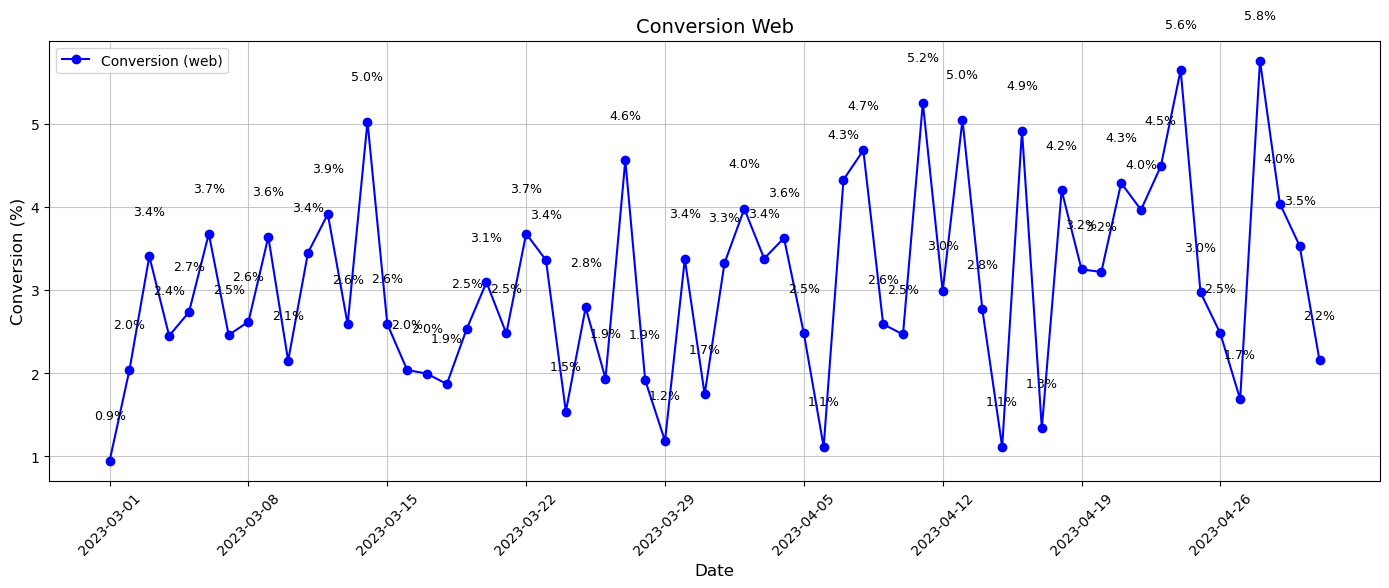

In [34]:
filtered_df = result_df[(result_df['date_group'] >= '2023-03-01') & (result_df['date_group'] <= '2023-05-01')]

filtered_df_no_bot = filtered_df[filtered_df['platform'] != 'bot']

platforms_no_bot = filtered_df_no_bot['platform'].unique()

for platform in platforms_no_bot:
    platform_data = filtered_df_no_bot[filtered_df_no_bot['platform'] == platform]

    plt.figure(figsize=(14, 6))

    plt.plot(platform_data['date_group'], platform_data['conversion'], marker='o', color='blue', label=f'Conversion ({platform})')

    for x, y in zip(platform_data['date_group'], platform_data['conversion']):
        plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)

    weekly_ticks = pd.date_range(start='2023-03-01', end='2023-05-01', freq='7D')

    plt.title(f'Conversion {platform.capitalize()}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Conversion (%)', fontsize=12)
    plt.xticks(ticks=weekly_ticks, labels=weekly_ticks.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('./charts/conversion_by_platform.png')
    plt.show()

### Стоимости реклам

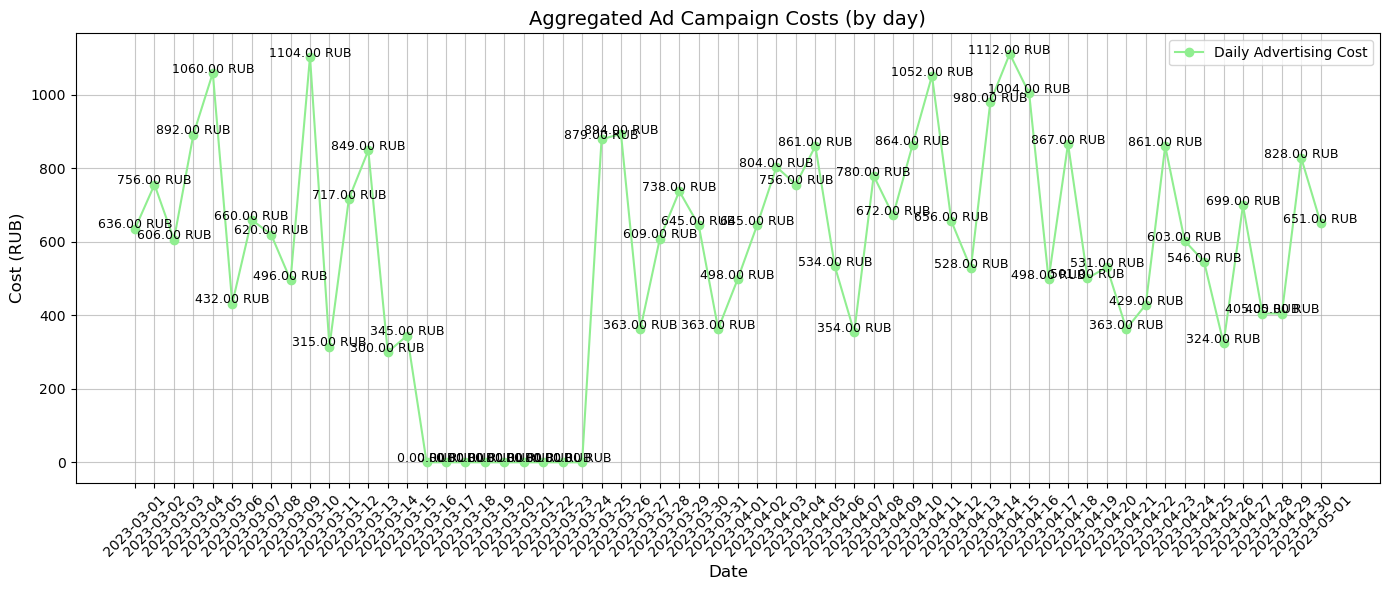

In [35]:
# Группировка данных по дням для получения затрат на рекламу (cost)
daily_cost = filtered_df.groupby('date_group')['cost'].sum().reset_index()

# Построение линейного графика
plt.figure(figsize=(14, 6))
plt.plot(daily_cost['date_group'], daily_cost['cost'], marker='o', color='lightgreen', label='Daily Advertising Cost')

# Добавление подписей значений к точкам
for x, y in zip(daily_cost['date_group'], daily_cost['cost']):
    plt.text(x, y + 0.5, f"{y:.2f} RUB", ha='center', fontsize=9)

# Настройка осей и графика
plt.title('Aggregated Ad Campaign Costs (by day)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cost (RUB)', fontsize=12)
plt.xticks(daily_cost['date_group'], daily_cost['date_group'].dt.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

# Добавление вертикальной сетки
plt.grid(axis='x', linestyle='-', alpha=0.7)

plt.tight_layout()
plt.savefig('./charts/aggregated_ad_campaign_costs.png')
plt.show()

### Визиты и регистрации с выделением рекламных кампаний

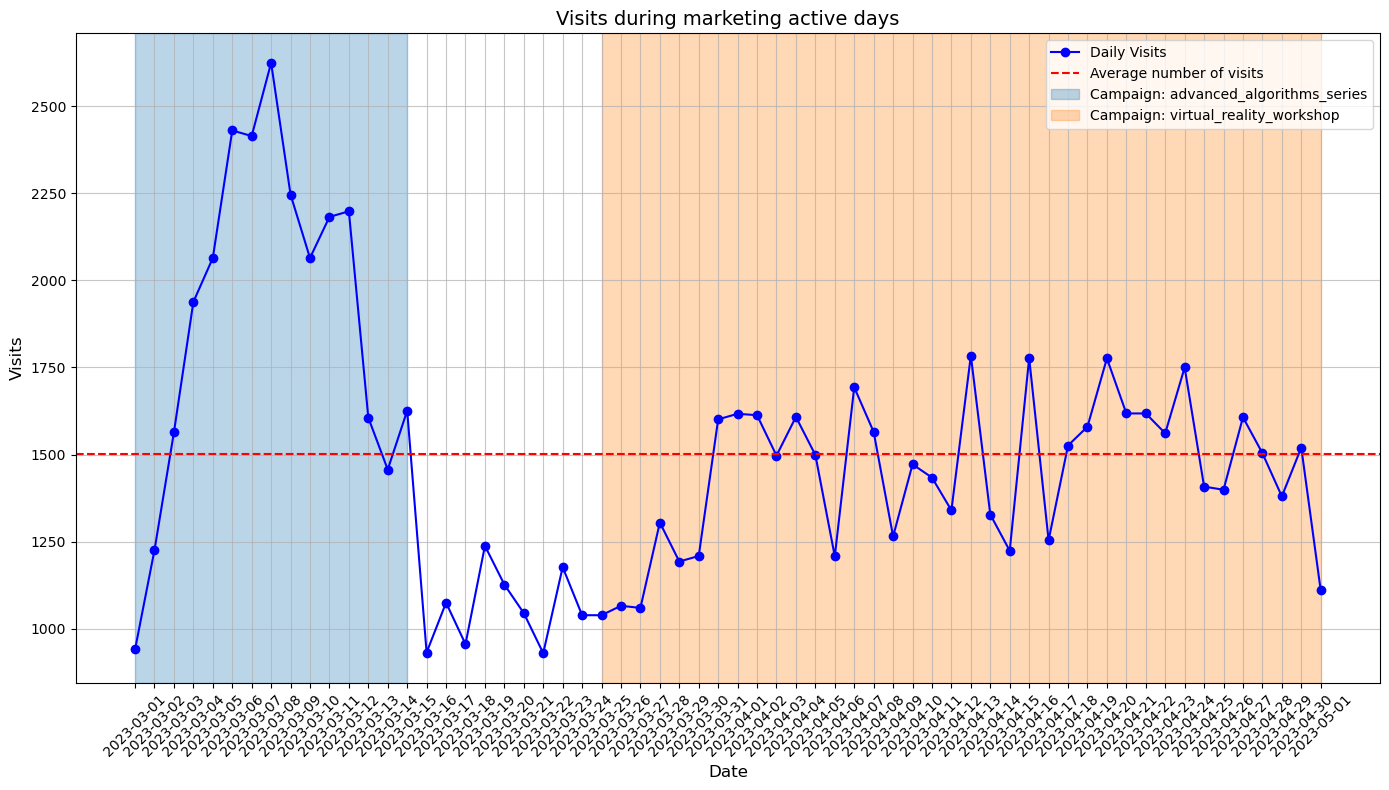

In [36]:
daily_visits = filtered_df.groupby('date_group')['visits'].sum().reset_index()

mean_visits = daily_visits['visits'].mean()

plt.figure(figsize=(14, 8))
plt.plot(daily_visits['date_group'], daily_visits['visits'], marker='o', color='blue', label='Daily Visits')

plt.axhline(mean_visits, color='red', linestyle='--', linewidth=1.5, label='Average number of visits')

campaigns = filtered_df['utm_campaign'].unique()
campaign_colors = {campaign: color for campaign, color in zip(campaigns, cm.tab20.colors)}

for campaign in campaigns:
    if campaign != 'none':
        campaign_data = filtered_df[filtered_df['utm_campaign'] == campaign]
        if not campaign_data.empty:
            start_date = campaign_data['date_group'].min()
            end_date = campaign_data['date_group'].max()
            plt.axvspan(
                start_date, end_date, alpha=0.3, 
                color=campaign_colors[campaign], label=f'Campaign: {campaign}'
            )

plt.title('Visits during marketing active days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Visits', fontsize=12)
plt.xticks(daily_visits['date_group'], daily_visits['date_group'].dt.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('./charts/visits_during_marketing_active_days.png')
plt.show()

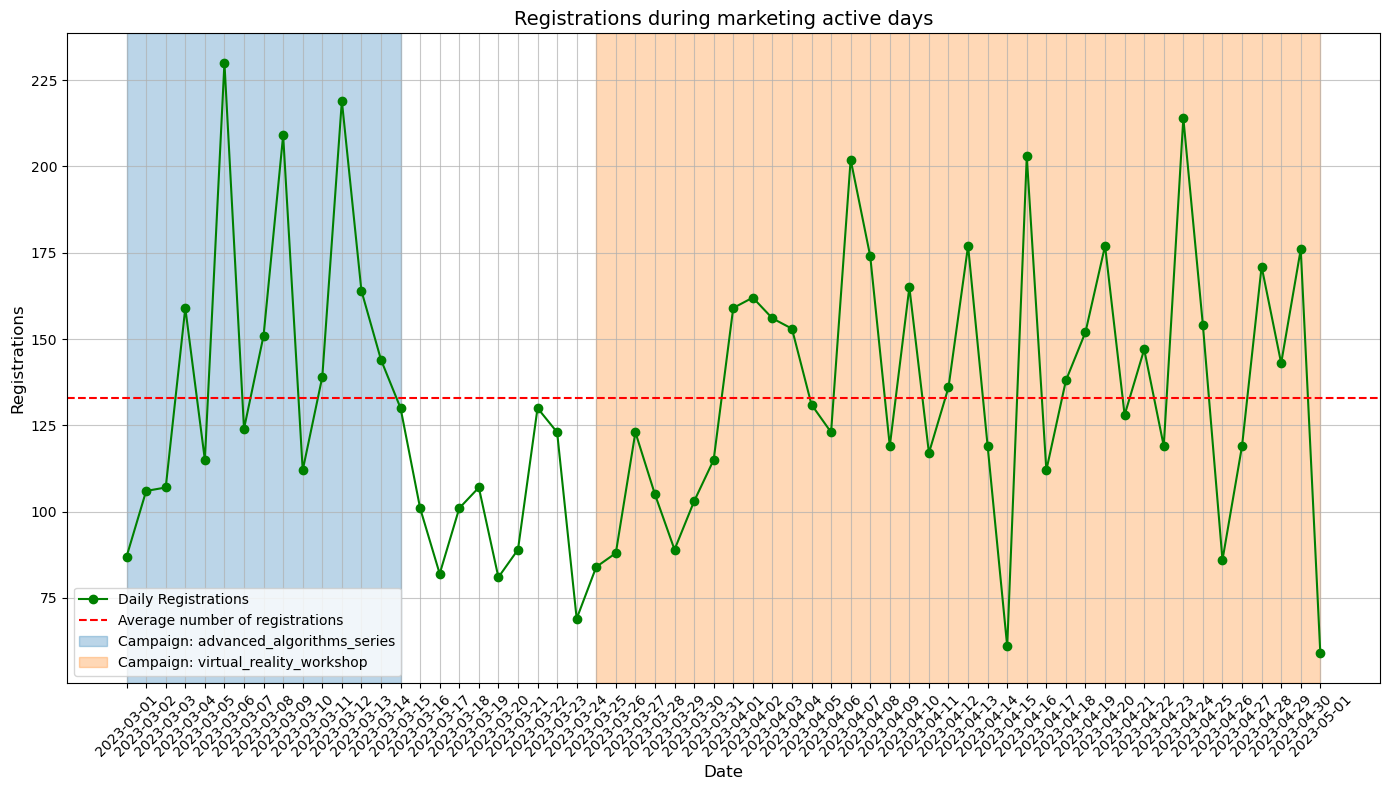

In [37]:
daily_registrations = filtered_df.groupby('date_group')['registrations'].sum().reset_index()

mean_registrations = daily_registrations['registrations'].mean()

plt.figure(figsize=(14, 8))
plt.plot(daily_registrations['date_group'], daily_registrations['registrations'], marker='o', color='green', label='Daily Registrations')

plt.axhline(mean_registrations, color='red', linestyle='--', linewidth=1.5, label='Average number of registrations')

campaigns = filtered_df['utm_campaign'].unique()
campaign_colors = {campaign: color for campaign, color in zip(campaigns, cm.tab20.colors)}

for campaign in campaigns:
    if campaign != 'none':
        campaign_data = filtered_df[filtered_df['utm_campaign'] == campaign]
        if not campaign_data.empty:
            start_date = campaign_data['date_group'].min()
            end_date = campaign_data['date_group'].max()
            plt.axvspan(
                start_date, end_date, alpha=0.3, 
                color=campaign_colors[campaign], label=f'Campaign: {campaign}'
            )

plt.title('Registrations during marketing active days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Registrations', fontsize=12)
plt.xticks(daily_registrations['date_group'], daily_registrations['date_group'].dt.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('./charts/registrations_during_marketing_active_days.png')
plt.show()